In [1]:
#my modules
import wrangle as wr
import explore as ex
import model as m

#Imports
import pandas as pd
import numpy as np

import nltk
# nltk.download('words')
# words = set(nltk.corpus.words.words())

imports loaded successfully, awaiting commands...


In [2]:
df = wr.check_file_exists_gbq('cfpb.csv', 'service_key.json')

csv file found and loaded


## Initial Thoughts

* There are going to be key words that match to a companies response
* Sentiment analysis will not be useful because most complaints will likely be negative

## Questions

1. Do specific issues tend to receive specific responses? For example, do issues related to fraud tend to receive more "closed with relief" responses compared to other issues?
2. Is there a relationship between consumer complaint and company response?
3. Do narratives with a neutral or positive sentiment analysis relating to bank account products lead to a response of closed with monetary relief?
4. Are there unique words associated with the most negative and most positive company response?
5. Is there a relationship/bias for servicemember tags in relation to company response?
6. Does narrative length relate to company response?

In [3]:
pd.set_option("display.max_colwidth", 250)

In [4]:
# df_clean = wr.clean_data(df)
# df_clean.to_parquet('df_clean.parquet')
df_clean = pd.read_parquet('df_clean.parquet')

# df_prep = wr.prep_narrative(df_clean)
# df_prep.to_parquet('df_prep.parquet')
df_prep = pd.read_parquet('df_prep.parquet')

# train, validate, test = wr.split_data(df_prep,"company_response_to_consumer")

# train.to_parquet('train.parquet')
# validate.to_parquet('validate.parquet')
# test.to_parquet('test.parquet')

train = pd.read_parquet('train.parquet')
validate = pd.read_parquet('validate.parquet')
test = pd.read_parquet('test.parquet')

## 2. Is there a relationship between consumer complaint words and company response?

In [5]:
word_counts = ex.get_words(train).sort_values(by='all',ascending=False)

Total Unique Words Found per Response: 122304



In [6]:
word_counts.to_parquet('word_counts.parquet')
word_counts = pd.read_parquet('word_counts.parquet')

In [7]:
word_counts

,all,explanation,no_money,money,timed_out,closed
account,1390487,1045109,257905,82549,2515,2409
credit,1333790,1028932,259158,40958,2668,2074
report,758566,576165,172216,7725,1389,1071
information,640808,485884,140081,12109,1658,1076
payment,602762,499750,60288,39111,1851,1762
...,...,...,...,...,...,...
notesi,1,1,0,0,0,0
notest,1,1,0,0,0,0
notesthey,1,1,0,0,0,0
creepily,1,1,0,0,0,0


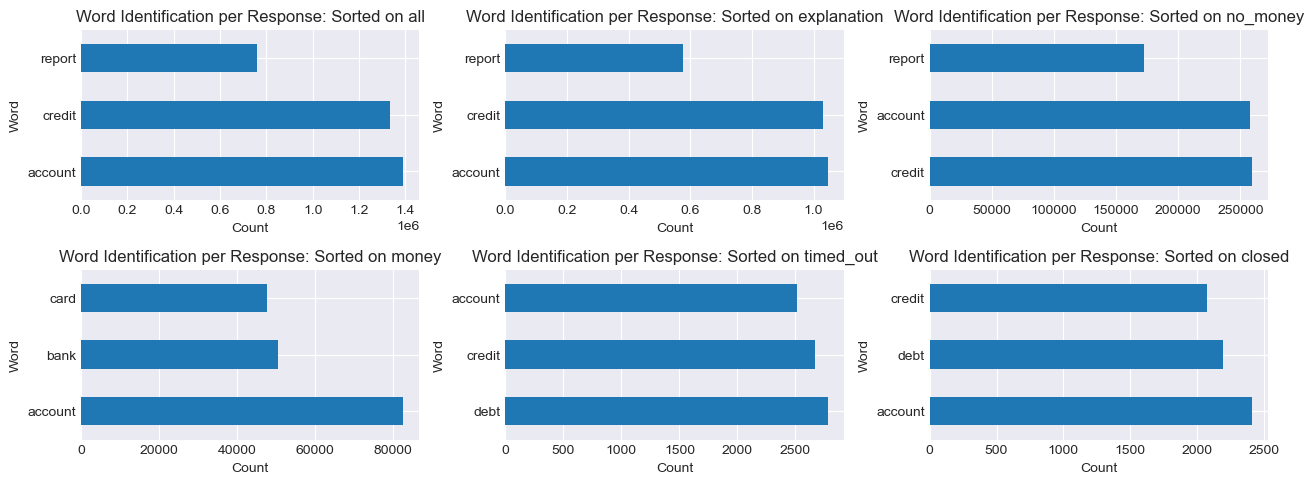

In [8]:
ex.unique_words(word_counts)

## 2a. Are there unique words associated with each product and is there a relationship between unique product words and possible response from the company?

In [9]:
word_counts_products = ex.get_words_products(train).sort_values(by='all',ascending=False)
word_counts_products.to_parquet('word_counts_products.parquet')
word_counts_products = pd.read_parquet('word_counts_products.parquet')

Total Unique Words Found per Product: 122304



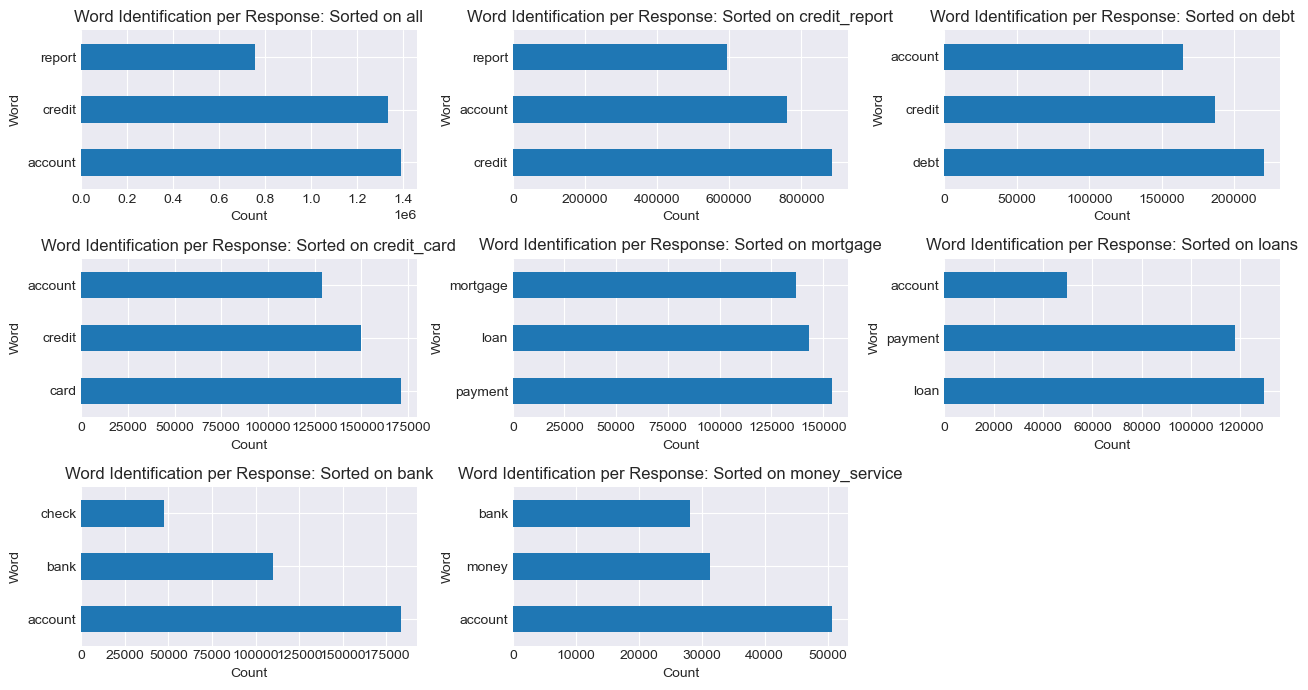

In [10]:
ex.unique_words(word_counts_products)

# Explore Takeaways:

## ***2. Is there a relationship between consumer complaint words and company response?***

* There is a relationship between words used in complaints and company responses. The words used relate to products that consumer's can complain about.
    
## Responses and top 5 words:

* Explanation
    * Account, Credit, Report, Payment, Information
        * This type of response looks like it could relate to credit reporting products
* Non-Monetary
    * Credit, Account, Report, Information, Reporting
* **Monetary**
    * Account, **Bank**, **Card**, Credit, Payment
        * This type of response looks like it could relate to credit card or bank products
* **Untimely Reponse**
    * **Debt**, Credit, Account, **Company**, **Loan**
        * This type of response looks like it could relate to debt products
* Closed
    * Account, Debt, Credit, Payment, Loan
---

## ***2a. Are there unique words associated with each product and is there a relationship between unique product words and possible response from the company?***

* There are unique words associated with each product.
        
## Products and top 5 words:
* Credit Report
    * Credit, Account, Report, Information, Reporting
        * matches up with hypothesis where this type of product might get a response of explanation or non-monetary relief
* Debt
    * **Debt**, Credit, Account, **Collection**, Report
        * matches up with hypothesis where this type of product might get an untimely response
* Credit Card
    * **Card**, Credit, Account, Payment, **Charge**
        * matches up with hypothesis where this type of product might get a response of monetary relief
* Mortgage
    * Payment, Loan, Mortgage, Would, **Time**
        * matches up with hypothesis where this type of product might get a response of closed
* Loans
    * Loan, Payment, Account, Would, Credit
        * matches up with hypothesis where this type of product might get a response of closed
* Bank
    * Account, Bank, **Check**, Money, Would
        * matches up with hypothesis where this type of product might get a response of monetary relief
* Money Service
    * Account, Money, Bank, **Paypal**, **Transaction**
        * matches up with hypothesis where this type of product might get a response of monetary relief

## 4. Are there unique bigrams associated with the most negative and most positive company response?

In [11]:
train.head(1)

,date_received,company_name,state,tags,company_response_to_consumer,product_bins,clean,lemon
944870,2015-05-12,"CITIBANK, N.A.",CA,Average Person,Closed with monetary relief,mortgage,it has been since that i first applied for the refinance as of today no decision or counter offer has been conveyed to me it s not a new loan and i am not a new customer to citibank my home loan is currently with citibank and has been for the pas...,since first applied refinance today decision counter offer conveyed new loan new customer citibank home loan currently citibank past several year week requested something provided item requested would get phone call requesting item response email...


In [12]:
word_counts.head()

,all,explanation,no_money,money,timed_out,closed
account,1390487,1045109,257905,82549,2515,2409
credit,1333790,1028932,259158,40958,2668,2074
report,758566,576165,172216,7725,1389,1071
information,640808,485884,140081,12109,1658,1076
payment,602762,499750,60288,39111,1851,1762


In [13]:
# top_20_money_bigrams = pd.Series(nltk.bigrams(word_counts.money.index)).value_counts(ascending=False)

In [14]:
# top_20_money_bigrams

In [15]:
# # Create an empty list
# bigram_list = []

# # Iterate through each column in word_counts
# for column in word_counts.columns:
#     # Create a unique variable name for each column's top 20 bigrams
#     variable_name = f"top_20_{column}_bigrams"
    
#     # Calculate the top 20 bigrams for the current column   
#     variable_info = pd.Series(nltk.bigrams(word_counts[column].index)).value_counts(ascending=False)
#     bigram_list.append(variable_info)
    
#     # Print the top 20 bigrams for the current column
#     print()
#     print(f'{variable_info}')
#     print(bigram_list)

## Do consumers in some states recieve more monetary relief than others?

In [16]:
train[train.company_response_to_consumer == 'Closed with monetary relief'].state.value_counts().head(10)

CA    4841
FL    2663
NY    2395
TX    2345
IL    1241
NJ    1228
GA    1135
PA    1129
VA     991
NC     877
Name: state, dtype: int64

In [17]:
train[train.company_response_to_consumer == 'Closed with non-monetary relief'].state.value_counts().head(10)

FL    15781
CA    13938
TX    12036
GA     9358
NY     7360
PA     6047
IL     5723
NC     4655
NJ     3889
MD     3174
Name: state, dtype: int64

In [18]:
# #encode
# X_train = m.encode(train)
# X_train = X_train.drop(columns=['date_received','company_response_to_consumer','clean','state','company_name','tags','product_bins'])
# y_train = train['company_response_to_consumer']
# X_val = m.encode(validate)
# X_val = X_val.drop(columns=['date_received','company_response_to_consumer','clean','state','company_name','tags','product_bins'])
# y_val = validate['company_response_to_consumer']
# X_test = m.encode(test)
# X_test = X_test.drop(columns=['date_received','company_response_to_consumer','clean','state','company_name','tags','product_bins'])
# y_test = test['company_response_to_consumer']
# X_train.head()

In [19]:
# #vectorizing
# X_train_cv,X_val_cv,X_test_cv = m.make_cv(X_train[['lemon']], X_val[['lemon']], X_test[['lemon']])
# X_train_tf,X_val_tf,X_test_tf = m.make_tfidf(X_train[['lemon']], X_val[['lemon']], X_test[['lemon']])

In [20]:
# #write to hdf did not work
# X_train_cv.to_hdf(key='key', path_or_buf='X_train_cv.hdf')

In [22]:
train.company_response_to_consumer.value_counts()
#take a sample from each class of how many rows you want to take to provide a more equal dataset and apply that through validate and test
#pandas .sample with the logical contiton where the field name = our class and take the sample


Closed with explanation            589373
Closed with non-monetary relief    123170
Closed with monetary relief         30578
Untimely response                    2675
Closed                               2245
Name: company_response_to_consumer, dtype: int64

In [21]:
train.shape

(748041, 8)

In [ ]:
#sampling is the way to go
#downsampling will not cause any loss of statistical voracity because of the size of the DF. We would have to completely rewrite the workflow

In [23]:
sm_train1 = int(round(len(train[train.company_response_to_consumer=='Closed with explanation'])*.2,0))
sm_train2 = int(round(len(train[train.company_response_to_consumer=='Closed with non-monetary relief'])*.2,0))
sm_train3 = int(round(len(train[train.company_response_to_consumer=='Closed with monetary relief'])*.2,0))
sm_train4 = int(round(len(train[train.company_response_to_consumer=='Untimely response'])*.2,0))
sm_train5 = int(round(len(train[train.company_response_to_consumer=='Closed'])*.2,0))
sm_val1 = int(round(len(validate[validate.company_response_to_consumer=='Closed with explanation'])*.2,0))
sm_val2 = int(round(len(validate[validate.company_response_to_consumer=='Closed with non-monetary relief'])*.2,0))
sm_val3 = int(round(len(validate[validate.company_response_to_consumer=='Closed with monetary relief'])*.2,0))
sm_val4 = int(round(len(validate[validate.company_response_to_consumer=='Untimely response'])*.2,0))
sm_val5 = int(round(len(validate[validate.company_response_to_consumer=='Closed'])*.2,0))
sm_test1 = int(round(len(test[test.company_response_to_consumer=='Closed with explanation'])*.2,0))
sm_test2 = int(round(len(test[test.company_response_to_consumer=='Closed with non-monetary relief'])*.2,0))
sm_test3 = int(round(len(test[test.company_response_to_consumer=='Closed with monetary relief'])*.2,0))
sm_test4 = int(round(len(test[test.company_response_to_consumer=='Untimely response'])*.2,0))
sm_test5 = int(round(len(test[test.company_response_to_consumer=='Closed'])*.2,0))

small_train1 = train[train.company_response_to_consumer=='Closed with explanation'].sample(sm_train1,random_state=123)
small_train2 = train[train.company_response_to_consumer=='Closed with non-monetary relief'].sample(sm_train2,random_state=123)
small_train3 = train[train.company_response_to_consumer=='Closed with monetary relief'].sample(sm_train3,random_state=123)
small_train4 = train[train.company_response_to_consumer=='Untimely response'].sample(sm_train4,random_state=123)
small_train5 = train[train.company_response_to_consumer=='Closed'].sample(sm_train5,random_state=123)
small_val1 = validate[validate.company_response_to_consumer=='Closed with explanation'].sample(sm_val1,random_state=123)
small_val2 = validate[validate.company_response_to_consumer=='Closed with non-monetary relief'].sample(sm_val2,random_state=123)
small_val3 = validate[validate.company_response_to_consumer=='Closed with monetary relief'].sample(sm_val3,random_state=123)
small_val4 = validate[validate.company_response_to_consumer=='Untimely response'].sample(sm_val4,random_state=123)
small_val5 = validate[validate.company_response_to_consumer=='Closed'].sample(sm_val5,random_state=123)
small_test1 = test[test.company_response_to_consumer=='Closed with explanation'].sample(sm_test1,random_state=123)
small_test2 = test[test.company_response_to_consumer=='Closed with non-monetary relief'].sample(sm_test2,random_state=123)
small_test3 = test[test.company_response_to_consumer=='Closed with monetary relief'].sample(sm_test3,random_state=123)
small_test4 = test[test.company_response_to_consumer=='Untimely response'].sample(sm_test4,random_state=123)
small_test5 = test[test.company_response_to_consumer=='Closed'].sample(sm_test5,random_state=123)

small_train = pd.concat([small_train1,small_train2,small_train3,small_train4,small_train5])
small_val = pd.concat([small_val1,small_val2,small_val3,small_val4,small_val5])
small_test = pd.concat([small_test1,small_test2,small_test3,small_test4,small_test5])

X_train = m.encode(small_train)
X_train = X_train.drop(columns=['date_received','company_response_to_consumer','clean','state','company_name','tags','product_bins'])
y_train = small_train['company_response_to_consumer']
X_val = m.encode(small_val)
X_val = X_val.drop(columns=['date_received','company_response_to_consumer','clean','state','company_name','tags','product_bins'])
y_val = small_val['company_response_to_consumer']
X_test = m.encode(small_test)
X_test = X_test.drop(columns=['date_received','company_response_to_consumer','clean','state','company_name','tags','product_bins'])
y_test = small_test['company_response_to_consumer']
X_train.head()

,lemon,Older American,"Older American, Servicemember",Servicemember,credit_card,credit_report,debt_collection,loans,money_service,mortgage
48045,trying contact grain technology inc debt owed since attempted call get live person filled contact information form several time past month want settle account willing work clearing debt want credit bureau remove debt credit report,0,0,0,0,0,1,0,0,0
1164880,bought large rug start vacation called filed dispute chase merchant responded fake invoice saying bought fabric shirt material walked door merchandise chase reinstated charge responded charge back provided addition evidence geo tag photo rug boug...,0,0,0,1,0,0,0,0,0
463976,original complaint went car dealership ohio look two vehicle vehicle walked salesperson available like supposed car appointment see already sold explained budget wanted stick given runaround hour told dealership could soft pull credit see kind nu...,0,0,0,0,1,0,0,0,0
490359,synopsis loan demand estate loan originated annum took loan day loan mortgagor passed away mortgage payment getting delay difficult time weve trying get catch loan even worked loan modification conditionally approved succeed month trial payment p...,0,0,0,0,0,0,0,0,1
316427,may concern writing dispute fraudulent charge account amount victim identity theft make authorize charge requesting charge removed finance charge related fraudulent amount credited well receive accurate statement request made pursuant fair credit...,0,0,0,0,1,0,0,0,0


In [26]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.datasets import make_hastie_10_2
from sklearn.metrics import accuracy_score